Condition 0 statistics:
  Median probability: 0.0000
  Q1: 0.0000, Q3: 0.0084
  IQR: 0.0084
Condition 1 statistics:
  Median probability: 0.0000
  Q1: 0.0000, Q3: 0.0000
  IQR: 0.0000
Condition 2 statistics:
  Median probability: 0.0000
  Q1: 0.0000, Q3: 0.0017
  IQR: 0.0017
Condition 3 statistics:
  Median probability: 0.0000
  Q1: 0.0000, Q3: 0.0108
  IQR: 0.0108
Condition 4 statistics:
  Median probability: 0.0013
  Q1: 0.0000, Q3: 0.0390
  IQR: 0.0390


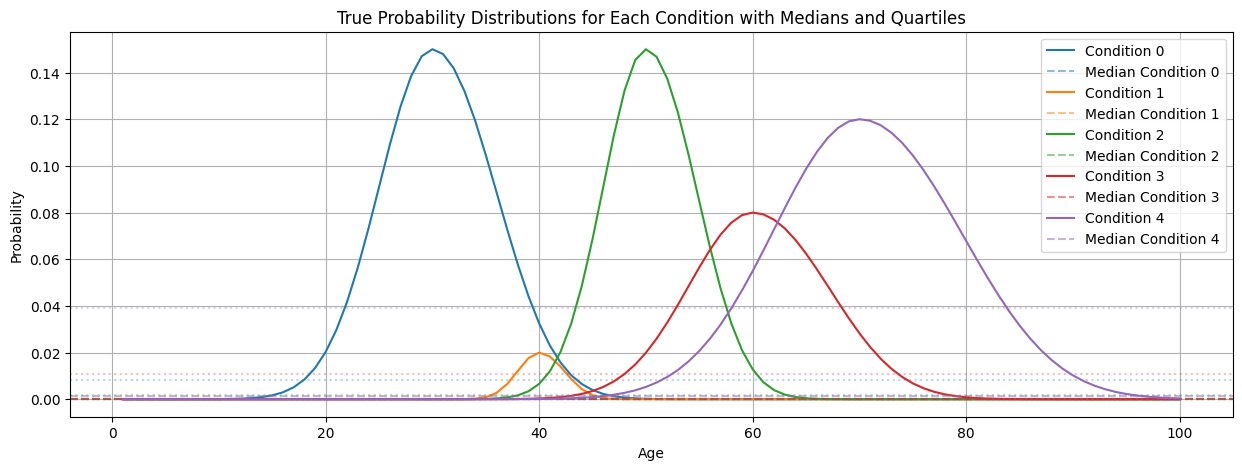

Starting training with alpha=0.5, beta=0.3, gamma=0.2
Epoch 1/30:
  Training Loss: 7.5922 (NE: 0.9448, Dist: 0.0275, Shape: 35.5577)
  Validation Loss: 1.1455 (NE: 0.3812, Dist: 0.0009, Shape: 4.7730)
  Learning Rate: 0.000690

Epoch 5/30:
  Training Loss: 2.3323 (NE: 0.3152, Dist: 0.0003, Shape: 10.8731)
  Validation Loss: 1.9326 (NE: 0.3075, Dist: 0.0002, Shape: 8.8937)
  Learning Rate: 0.006044

Epoch 10/30:
  Training Loss: 1.2030 (NE: 0.2968, Dist: 0.0002, Shape: 5.2727)
  Validation Loss: 0.6409 (NE: 0.2987, Dist: 0.0001, Shape: 2.4577)
  Learning Rate: 0.009943

Epoch 15/30:
  Training Loss: 0.8746 (NE: 0.2935, Dist: 0.0001, Shape: 3.6391)
  Validation Loss: 0.5961 (NE: 0.2935, Dist: 0.0001, Shape: 2.2468)
  Learning Rate: 0.008111

Epoch 20/30:
  Training Loss: 0.7124 (NE: 0.2949, Dist: 0.0001, Shape: 2.8246)
  Validation Loss: 0.8005 (NE: 0.2939, Dist: 0.0000, Shape: 3.2675)
  Learning Rate: 0.004618

Epoch 25/30:
  Training Loss: 0.7314 (NE: 0.2885, Dist: 0.0001, Shape: 2.936

<Figure size 1500x800 with 0 Axes>

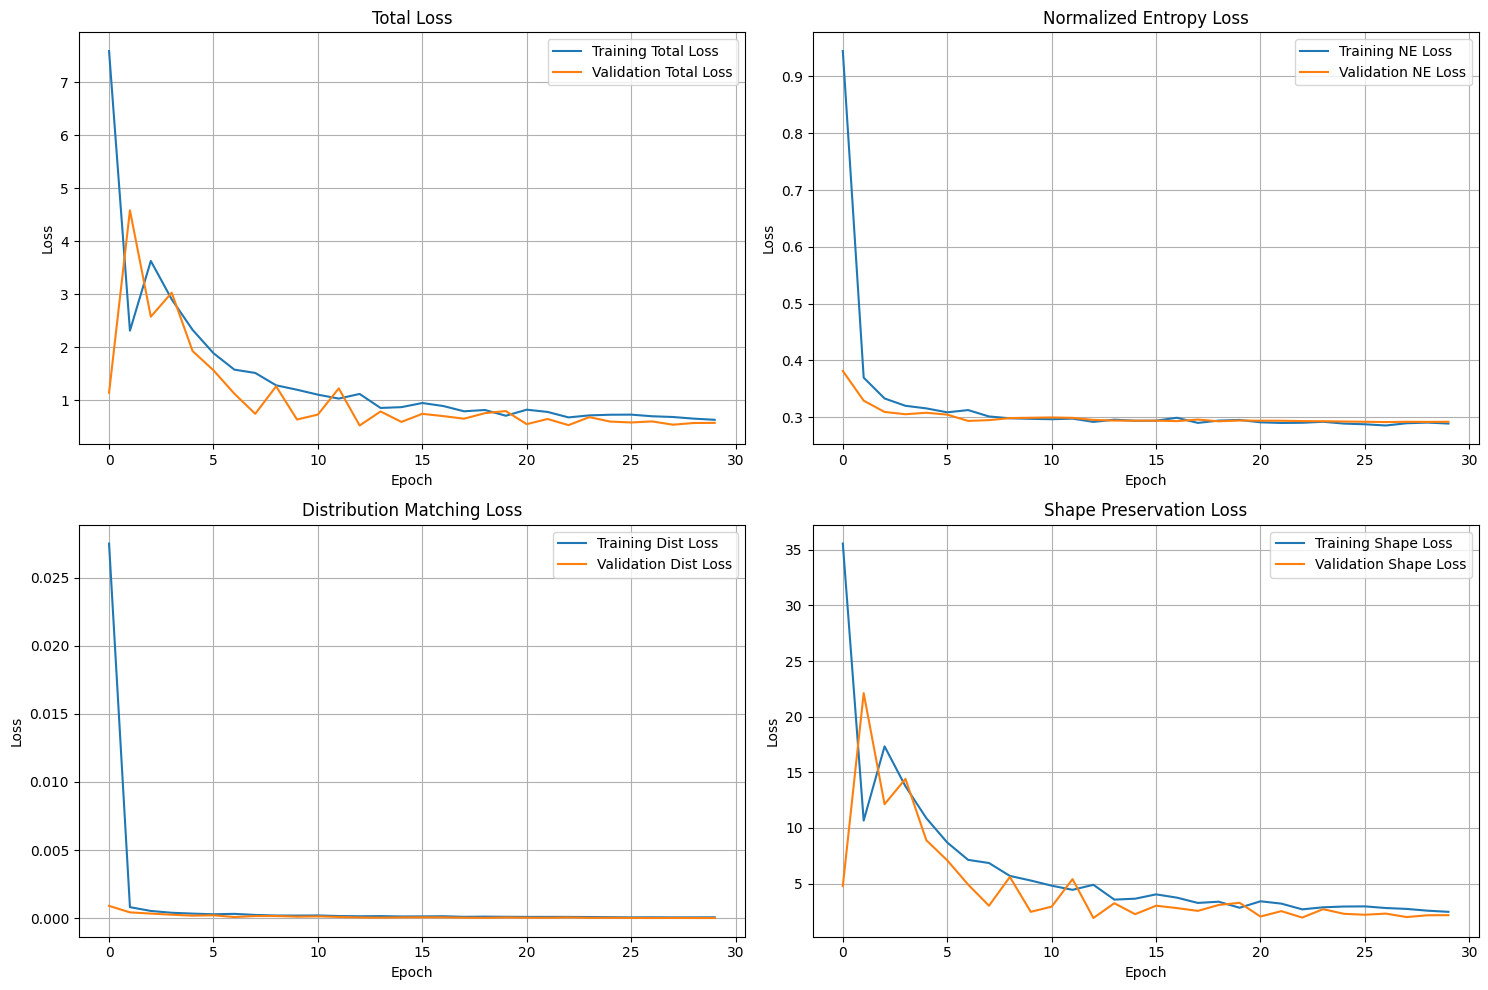

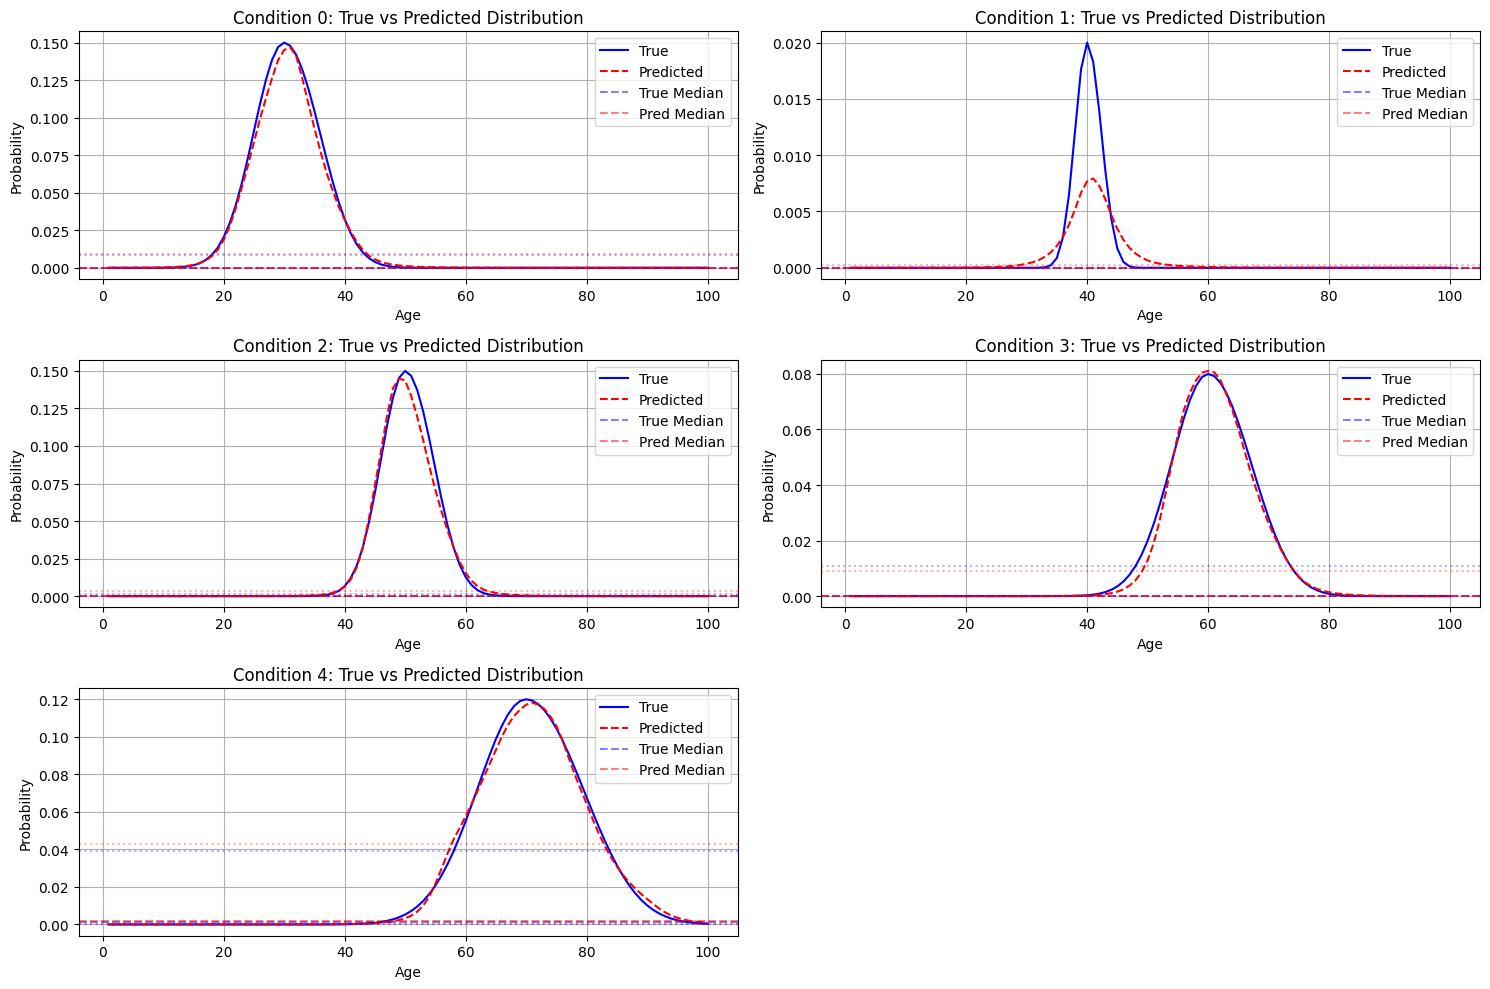


Final Distribution Alignment Statistics:
Condition 0:
  MSE: 0.000012
  True Median: 0.0000, Predicted Median: 0.0001, Diff: 0.0001
  True Q1: 0.0000, Predicted Q1: 0.0000, Diff: 0.0000
  True Q3: 0.0089, Predicted Q3: 0.0091, Diff: 0.0002
  True IQR: 0.0089, Predicted IQR: 0.0091

Condition 1:
  MSE: 0.000005
  True Median: 0.0000, Predicted Median: 0.0000, Diff: 0.0000
  True Q1: 0.0000, Predicted Q1: 0.0000, Diff: 0.0000
  True Q3: 0.0000, Predicted Q3: 0.0002, Diff: 0.0002
  True IQR: 0.0000, Predicted IQR: 0.0002

Condition 2:
  MSE: 0.000017
  True Median: 0.0000, Predicted Median: 0.0001, Diff: 0.0001
  True Q1: 0.0000, Predicted Q1: 0.0000, Diff: 0.0000
  True Q3: 0.0017, Predicted Q3: 0.0031, Diff: 0.0014
  True IQR: 0.0017, Predicted IQR: 0.0031

Condition 3:
  MSE: 0.000003
  True Median: 0.0000, Predicted Median: 0.0001, Diff: 0.0001
  True Q1: 0.0000, Predicted Q1: 0.0000, Diff: 0.0000
  True Q3: 0.0114, Predicted Q3: 0.0089, Diff: 0.0025
  True IQR: 0.0114, Predicted IQR

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader, random_split

def generate_skewed_gaussian(age, mu, std, p_center):
    z = (age - mu) / std
    base_prob = p_center * np.exp(-0.5 * z ** 2)
    if age > mu:
        skew_factor = 1 + 0.15 * (z ** 2)
        base_prob *= skew_factor
    return min(base_prob, 1.0)

class MedicalDataset(Dataset):
    def __init__(self, ages, condition_ids, labels, true_probs, age_mean, age_std):
        self.ages = torch.FloatTensor((ages - age_mean) / age_std).reshape(-1, 1)
        self.condition_ids = torch.LongTensor(condition_ids)
        self.labels = torch.FloatTensor(labels).reshape(-1, 1)
        self.true_probs = torch.FloatTensor(true_probs).reshape(-1, 1)
        
    def __len__(self):
        return len(self.ages)
    
    def __getitem__(self, idx):
        return (self.ages[idx], self.condition_ids[idx]), self.labels[idx], self.true_probs[idx]

class ProbabilityNN(nn.Module):
    def __init__(self, num_conditions, embedding_dim=16, hidden_dim=128, dropout_rate=0.2):
        super().__init__()
        self.condition_embedding = nn.Embedding(num_conditions, embedding_dim)
        input_size = 1 + embedding_dim
        
        # Enhanced network with more capacity and residual connections
        self.input_layer = nn.Sequential(
            nn.Linear(input_size, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout_rate)
        )
        
        self.hidden_layer1 = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout_rate)
        )
        
        self.hidden_layer2 = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout_rate)
        )
        
        self.output_layer = nn.Sequential(
            nn.Linear(hidden_dim, 1),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        age, condition_id = x
        condition_emb = self.condition_embedding(condition_id)
        combined_input = torch.cat([age, condition_emb], dim=1)
        
        x = self.input_layer(combined_input)
        
        # Residual connection 1
        res1 = x
        x = self.hidden_layer1(x)
        x = x + res1  # Residual connection
        
        # Residual connection 2
        res2 = x
        x = self.hidden_layer2(x)
        x = x + res2  # Residual connection
        
        return self.output_layer(x)

def combined_loss(predictions, labels, true_probs, condition_ids, condition_medians, condition_quartiles, alpha=0.5, beta=0.3, gamma=0.2):
    """
    Combined loss function with:
    1. Normalized entropy loss using condition-specific medians
    2. Distribution matching loss (MSE between predicted and true probabilities)
    3. Shape preservation loss based on quartile differences
    
    Parameters:
    predictions: predicted probabilities
    labels: true labels (1 or 0)
    true_probs: true probabilities (continuous values between 0 and 1)
    condition_ids: condition identifiers for each sample
    condition_medians: array of median probabilities for each condition
    condition_quartiles: array of quartiles for each condition for shape preservation
    alpha, beta, gamma: weights for the different loss components
    """
    eps = 1e-7
    predictions = torch.clamp(predictions, eps, 1 - eps)
    
    # Get the median probabilities for each sample based on its condition ID
    batch_medians = torch.tensor([condition_medians[cid.item()] for cid in condition_ids], 
                                device=predictions.device).reshape(-1, 1)
    
    # 1. Normalized Entropy Loss
    ce = -labels * torch.log2(predictions) - (1 - labels) * torch.log2(1 - predictions)
    ne_denominator = -labels * torch.log2(batch_medians) - (1 - labels) * torch.log2(1 - batch_medians)
    ne_loss = ce.sum() / ne_denominator.sum()
    
    # 2. Distribution Matching Loss (MSE between predicted and true probabilities)
    dist_loss = torch.mean((predictions - true_probs) ** 2)
    
    # 3. Shape Preservation Loss
    # For each condition, ensure the shape is preserved by penalizing deviation from expected quartile differences
    shape_loss = 0.0
    for cid in range(len(condition_quartiles)):
        condition_mask = (condition_ids == cid)
        if condition_mask.sum() > 0:
            cond_preds = predictions[condition_mask]
            # Safely handle empty tensors or small batches
            if cond_preds.numel() > 3:
                cond_pred_quartiles = torch.tensor([
                    torch.quantile(cond_preds.flatten(), 0.25),
                    torch.quantile(cond_preds.flatten(), 0.5),
                    torch.quantile(cond_preds.flatten(), 0.75)
                ])
            else:
                # Use mean as approximation if not enough data points
                cond_pred_quartiles = torch.tensor([
                    torch.mean(cond_preds) * 0.8,
                    torch.mean(cond_preds),
                    torch.mean(cond_preds) * 1.2
                ])
            
            # Calculate predicted inter-quartile differences
            pred_q_diffs = cond_pred_quartiles[1:] - cond_pred_quartiles[:-1]
            
            # Compare with true inter-quartile differences
            q_array = np.array(condition_quartiles[cid])
            true_q_diffs = q_array[1:] - q_array[:-1]
            true_q_diffs = torch.tensor(true_q_diffs, device=pred_q_diffs.device)
            
            # Normalize the differences to make it scale-invariant
            norm_factor = true_q_diffs.abs().sum()
            if norm_factor > 1e-6:  # Prevent division by very small numbers
                shape_loss += torch.sum(torch.abs(pred_q_diffs - true_q_diffs)) / norm_factor
            else:
                # If all quartiles are the same, just penalize any deviation
                shape_loss += torch.sum(torch.abs(pred_q_diffs))
    
    # Combine the losses
    total_loss = alpha * ne_loss + beta * dist_loss + gamma * shape_loss
    
    return total_loss, ne_loss, dist_loss, shape_loss

def main(mu_list=None, std_list=None, p_center_list=None,
         embedding_dim=16, hidden_dim=128, n_epochs=30, batch_size=1000, train_split=0.9, 
         learning_rate=0.01, alpha=0.5, beta=0.3, gamma=0.2):
    # Set default parameters if none provided
    if mu_list is None:
        mu_list = [30, 40, 50, 60, 70]
    if std_list is None:
        std_list = [5, 2, 4, 6, 8]
    if p_center_list is None:
        p_center_list = [0.15, 0.02, 0.15, 0.08, 0.12]
    
    # Determine number of conditions from parameter lengths
    K = len(mu_list)
    T = int(100000 / K)
    TOTAL_SAMPLES = T * K

    torch.manual_seed(42)
    np.random.seed(42)

    # Pre-allocate arrays for dataset
    all_ages = np.zeros(TOTAL_SAMPLES, dtype=np.int32)
    all_condition_ids = np.zeros(TOTAL_SAMPLES, dtype=np.int32)
    all_labels = np.zeros(TOTAL_SAMPLES, dtype=np.int32)
    all_true_probs = np.zeros(TOTAL_SAMPLES, dtype=np.float32)

    for condition_id in range(K):
        start_idx = condition_id * T
        end_idx = (condition_id + 1) * T
        ages = np.random.randint(1, 101, size=T)
        probabilities = np.array([
            generate_skewed_gaussian(age, mu_list[condition_id], std_list[condition_id], p_center_list[condition_id])
            for age in ages
        ])
        labels = np.random.binomial(n=1, p=probabilities)
        all_ages[start_idx:end_idx] = ages
        all_condition_ids[start_idx:end_idx] = condition_id
        all_labels[start_idx:end_idx] = labels
        all_true_probs[start_idx:end_idx] = probabilities

    # Compute statistics for each condition
    condition_medians = []
    condition_quartiles = []
    
    for condition_id in range(K):
        condition_mask = all_condition_ids == condition_id
        condition_probs = all_true_probs[condition_mask]
        
        # Calculate median
        median_prob = np.median(condition_probs)
        condition_medians.append(median_prob)
        
        # Calculate quartiles for shape preservation
        q1 = np.quantile(condition_probs, 0.25)
        q2 = median_prob  # median is already the 50th percentile
        q3 = np.quantile(condition_probs, 0.75)
        # Store as numpy array instead of list
        condition_quartiles.append(np.array([q1, q2, q3]))
        
        print(f"Condition {condition_id} statistics:")
        print(f"  Median probability: {median_prob:.4f}")
        print(f"  Q1: {q1:.4f}, Q3: {q3:.4f}")
        print(f"  IQR: {q3-q1:.4f}")
    
    condition_medians = np.array(condition_medians)

    # Normalize ages
    age_mean = np.mean(all_ages)
    age_std = np.std(all_ages)

    # Plot true probability distributions for each condition
    plt.figure(figsize=(15, 5))
    age_range = np.arange(1, 101)
    for condition_id in range(K):
        true_probs = [generate_skewed_gaussian(age, mu_list[condition_id],
                                                 std_list[condition_id],
                                                 p_center_list[condition_id])
                      for age in age_range]
        plt.plot(age_range, true_probs, label=f'Condition {condition_id}')
        
        # Add lines for quartiles
        q1, q2, q3 = condition_quartiles[condition_id]
        plt.axhline(y=q1, color=f'C{condition_id}', linestyle=':', alpha=0.3)
        plt.axhline(y=q2, color=f'C{condition_id}', linestyle='--', alpha=0.5, 
                   label=f'Median Condition {condition_id}')
        plt.axhline(y=q3, color=f'C{condition_id}', linestyle=':', alpha=0.3)
    
    plt.xlabel('Age')
    plt.ylabel('Probability')
    plt.title('True Probability Distributions for Each Condition with Medians and Quartiles')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Prepare data loaders with true probabilities
    dataset = MedicalDataset(all_ages, all_condition_ids, all_labels, all_true_probs, age_mean, age_std)
    
    # Use a generator with fixed seed for reproducibility
    generator = torch.Generator().manual_seed(42)
    train_size = int(train_split * len(dataset))
    test_size = len(dataset) - train_size
    train_dataset, test_dataset = random_split(dataset, [train_size, test_size], generator=generator)
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size)

    # Initialize model, optimizer, scheduler
    model = ProbabilityNN(num_conditions=K, embedding_dim=embedding_dim, hidden_dim=hidden_dim)
    optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=1e-4)
    scheduler = optim.lr_scheduler.OneCycleLR(
        optimizer, max_lr=learning_rate, 
        steps_per_epoch=len(train_loader), 
        epochs=n_epochs
    )

    # Training and validation loss tracking
    plt.figure(figsize=(15, 8))
    train_losses = {'total': [], 'ne': [], 'dist': [], 'shape': []}
    val_losses = {'total': [], 'ne': [], 'dist': [], 'shape': []}

    print(f"Starting training with alpha={alpha}, beta={beta}, gamma={gamma}")
    
    for epoch in range(n_epochs):
        model.train()
        epoch_losses = {'total': [], 'ne': [], 'dist': [], 'shape': []}
        
        for (age_batch, condition_batch), target_batch, true_prob_batch in train_loader:
            optimizer.zero_grad()
            output = model((age_batch, condition_batch))
            
            loss, ne_loss, dist_loss, shape_loss = combined_loss(
                output, target_batch, true_prob_batch, condition_batch, 
                condition_medians, condition_quartiles,
                alpha, beta, gamma
            )
            
            loss.backward()
            optimizer.step()
            scheduler.step()
            
            epoch_losses['total'].append(loss.item())
            epoch_losses['ne'].append(ne_loss.item())
            epoch_losses['dist'].append(dist_loss.item())
            epoch_losses['shape'].append(shape_loss.item())
        
        # Validation
        model.eval()
        val_epoch_losses = {'total': 0, 'ne': 0, 'dist': 0, 'shape': 0}
        val_batches = 0
        
        with torch.no_grad():
            for (age_batch, condition_batch), target_batch, true_prob_batch in test_loader:
                output = model((age_batch, condition_batch))
                
                val_loss, val_ne, val_dist, val_shape = combined_loss(
                    output, target_batch, true_prob_batch, condition_batch,
                    condition_medians, condition_quartiles,
                    alpha, beta, gamma
                )
                
                val_epoch_losses['total'] += val_loss.item()
                val_epoch_losses['ne'] += val_ne.item()
                val_epoch_losses['dist'] += val_dist.item()
                val_epoch_losses['shape'] += val_shape.item()
                val_batches += 1
        
        # Average losses
        for key in val_epoch_losses:
            val_epoch_losses[key] /= val_batches
            train_losses[key].append(np.mean(epoch_losses[key]))
            val_losses[key].append(val_epoch_losses[key])
        
        # Print progress
        if (epoch + 1) % 5 == 0 or epoch == 0:
            print(f'Epoch {epoch + 1}/{n_epochs}:')
            print(f'  Training Loss: {train_losses["total"][-1]:.4f} (NE: {train_losses["ne"][-1]:.4f}, '
                  f'Dist: {train_losses["dist"][-1]:.4f}, Shape: {train_losses["shape"][-1]:.4f})')
            print(f'  Validation Loss: {val_losses["total"][-1]:.4f} (NE: {val_losses["ne"][-1]:.4f}, '
                  f'Dist: {val_losses["dist"][-1]:.4f}, Shape: {val_losses["shape"][-1]:.4f})')
            print(f'  Learning Rate: {scheduler.get_last_lr()[0]:.6f}\n')

    # Plot training progress
    plt.figure(figsize=(15, 10))
    
    plt.subplot(2, 2, 1)
    plt.plot(train_losses['total'], label='Training Total Loss')
    plt.plot(val_losses['total'], label='Validation Total Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Total Loss')
    plt.legend()
    plt.grid(True)
    
    plt.subplot(2, 2, 2)
    plt.plot(train_losses['ne'], label='Training NE Loss')
    plt.plot(val_losses['ne'], label='Validation NE Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Normalized Entropy Loss')
    plt.legend()
    plt.grid(True)
    
    plt.subplot(2, 2, 3)
    plt.plot(train_losses['dist'], label='Training Dist Loss')
    plt.plot(val_losses['dist'], label='Validation Dist Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Distribution Matching Loss')
    plt.legend()
    plt.grid(True)
    
    plt.subplot(2, 2, 4)
    plt.plot(train_losses['shape'], label='Training Shape Loss')
    plt.plot(val_losses['shape'], label='Validation Shape Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Shape Preservation Loss')
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()

    # Plot predictions vs true probabilities
    plt.figure(figsize=(15, 10))
    age_range_tensor = torch.FloatTensor((np.arange(1, 101) - age_mean) / age_std).reshape(-1, 1)
    model.eval()
    
    # Create a grid of plots for each condition
    for condition_id in range(K):
        plt.subplot(3, 2, condition_id + 1)
        
        condition_ids = torch.full((100,), condition_id, dtype=torch.long)
        with torch.no_grad():
            predictions = model((age_range_tensor, condition_ids))
        
        true_probs = [generate_skewed_gaussian(age, mu_list[condition_id],
                                               std_list[condition_id],
                                               p_center_list[condition_id])
                      for age in range(1, 101)]
        
        plt.plot(range(1, 101), true_probs, label=f'True', color='blue', linestyle='-')
        plt.plot(range(1, 101), predictions.numpy(), label=f'Predicted', color='red', linestyle='--')
        
        # Add quartile lines
        q1, q2, q3 = condition_quartiles[condition_id]
        plt.axhline(y=q1, color='blue', linestyle=':', alpha=0.3)
        plt.axhline(y=q2, color='blue', linestyle='--', alpha=0.5, label='True Median')
        plt.axhline(y=q3, color='blue', linestyle=':', alpha=0.3)
        
        # Add predicted quartiles
        pred_q1 = np.quantile(predictions.numpy(), 0.25)
        pred_q2 = np.quantile(predictions.numpy(), 0.5)
        pred_q3 = np.quantile(predictions.numpy(), 0.75)
        plt.axhline(y=pred_q1, color='red', linestyle=':', alpha=0.3)
        plt.axhline(y=pred_q2, color='red', linestyle='--', alpha=0.5, label='Pred Median')
        plt.axhline(y=pred_q3, color='red', linestyle=':', alpha=0.3)
        
        plt.xlabel('Age')
        plt.ylabel('Probability')
        plt.title(f'Condition {condition_id}: True vs Predicted Distribution')
        plt.legend()
        plt.grid(True)
    
    plt.tight_layout()
    plt.show()

    # Print final statistics
    print("\nFinal Distribution Alignment Statistics:")
    for condition_id in range(K):
        condition_ids = torch.full((100,), condition_id, dtype=torch.long)
        with torch.no_grad():
            predictions = model((age_range_tensor, condition_ids))
        
        true_probs = np.array([
            generate_skewed_gaussian(age, mu_list[condition_id], std_list[condition_id], p_center_list[condition_id])
            for age in range(1, 101)
        ])
        
        pred_probs = predictions.numpy().flatten()
        
        # Calculate statistics
        true_median = np.median(true_probs)
        pred_median = np.median(pred_probs)
        true_q1 = np.quantile(true_probs, 0.25)
        pred_q1 = np.quantile(pred_probs, 0.25)
        true_q3 = np.quantile(true_probs, 0.75)
        pred_q3 = np.quantile(pred_probs, 0.75)
        
        # MSE between distributions
        mse = np.mean((true_probs - pred_probs) ** 2)
        
        print(f"Condition {condition_id}:")
        print(f"  MSE: {mse:.6f}")
        print(f"  True Median: {true_median:.4f}, Predicted Median: {pred_median:.4f}, Diff: {abs(true_median-pred_median):.4f}")
        print(f"  True Q1: {true_q1:.4f}, Predicted Q1: {pred_q1:.4f}, Diff: {abs(true_q1-pred_q1):.4f}")
        print(f"  True Q3: {true_q3:.4f}, Predicted Q3: {pred_q3:.4f}, Diff: {abs(true_q3-pred_q3):.4f}")
        print(f"  True IQR: {true_q3-true_q1:.4f}, Predicted IQR: {pred_q3-pred_q1:.4f}")
        print()

if __name__ == "__main__":
    main()